In [1]:
# sudo apt-get update
# sudo apt-get install -y libsm6 libxext6 libxrender-dev
# pip install opencv-python

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras import regularizers

from platform import python_version

import numpy as np
import pandas as pd
import random
import cv2
import csv
from matplotlib import pyplot as plt

import os,shutil
from PIL import ImageFile
from openpyxl import load_workbook, Workbook
from shutil import copyfile

import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc 
from skimage.io import imread
from skimage import data, img_as_float
from skimage import exposure
from skimage.transform import rescale, resize

from PIL import Image
import imagesize

In [2]:
print('tensorflow version:',tf.__version__) 
print('python version:',python_version())

tensorflow version: 2.0.0
python version: 3.7.9


In [3]:
# if '/device:GPU:0' then works on gpu
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
# Ensure that size of photo > 224 pixel
def check_size(photoId):
    width, height = imagesize.get(os.path.join('/home/b05501009/Jubo/7_30/CropedImages',photoId))
    if width < 224 or height < 224 :
        return False
    else:
        return True
    
# For drawing
def autolabel(rects):
"""
Attach a text label above each bar displaying its height
"""
for rect in rects:
    height = rect.get_height()
    plt.text(rect.get_x()+ rect.get_width()/2, 1.01*height,
            '%d' % int(height),
            ha='center', va='bottom')
     
def autolabel2(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+ rect.get_width()/2, 1.2*height,
                '%d' % int(height),
                ha='center', va='bottom')     

[75, 260, 118, 181, 0]


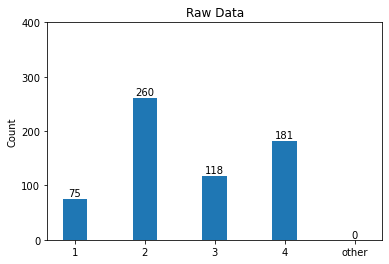

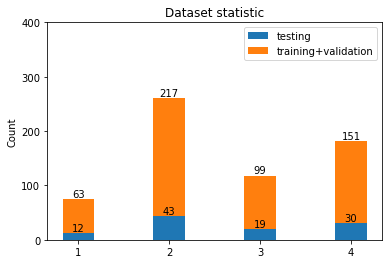

In [5]:
# data statistic
df = pd.read_excel('/home/b05501009/Jubo/8_31/croped_images_list_yc.xlsx')

traincsv = open('/home/b05501009/Jubo/9_17/dataset/train.csv','w')
trainwriter = csv.writer(traincsv)
trainwriter.writerow(['path','label','origin label'])


testcsv = open('/home/b05501009/Jubo/9_17/dataset/test.csv','w')
testwriter = csv.writer(testcsv)
testwriter.writerow(['path','label','origin label'])


one_count = 0
two_count = 0
thr_count = 0
for_count = 0
oth_count = 0

one_list = []
two_list = []
thr_list = []
for_list = []

one_origin_list = []
two_origin_list = []
thr_origin_list = []
for_origin_list = []

for i in range(len(df)):
    if check_size(df['photoId'][i]):
        if df['判斷等級'][i] == 1:
            if not os.path.isfile('/home/b05501009/Jubo/7_30/CropedImages/'+df['photoId'][i]):
                #print(df['photoId'][i])
                continue
            one_list.append(df['photoId'][i])
            one_origin_list.append(df['等級'][i])
            one_count += 1

        elif df['判斷等級'][i] == 2:        
            if not os.path.isfile('/home/b05501009/Jubo/7_30/CropedImages/'+df['photoId'][i]):
                #print(df['photoId'][i])
                continue
            two_list.append(df['photoId'][i])
            two_origin_list.append(df['等級'][i])
            two_count += 1
        elif df['判斷等級'][i] == 3:
            if not os.path.isfile('/home/b05501009/Jubo/7_30/CropedImages/'+df['photoId'][i]):
                #print(df['photoId'][i])
                continue
            thr_list.append(df['photoId'][i])
            thr_origin_list.append(df['等級'][i])
            thr_count += 1
        elif df['判斷等級'][i] == 4:
            if not os.path.isfile('/home/b05501009/Jubo/7_30/CropedImages/'+df['photoId'][i]):
                #print(df['photoId'][i])
                continue
            for_list.append(df['photoId'][i])
            for_origin_list.append(df['等級'][i])
            for_count += 1
        else:
            if not os.path.isfile('/home/b05501009/Jubo/7_30/CropedImages/'+df['photoId'][i]):
                #print(df['photoId'][i])
                continue
            oth_count += 1

# Shuffle and create training and testing set
random.seed(10)  
random.shuffle(one_list)
random.shuffle(two_list)
random.shuffle(thr_list)
random.shuffle(for_list)
        
for i in range(len(one_list)):
    if i < 12:
        testwriter.writerow([one_list[i],1,one_origin_list[i]])
    else:
        trainwriter.writerow([one_list[i],1,one_origin_list[i]])
    
for i in range(len(two_list)):
    if i < 43:
        testwriter.writerow([two_list[i],2,two_origin_list[i]])
    else:
        trainwriter.writerow([two_list[i],2,two_origin_list[i]])
        
for i in range(len(thr_list)):
    if i < 19:
        testwriter.writerow([thr_list[i],3,thr_origin_list[i]])
    else:
        trainwriter.writerow([thr_list[i],3,thr_origin_list[i]])
        
for i in range(len(for_list)):
    if i < 30:
        testwriter.writerow([for_list[i],4,for_origin_list[i]])
    else:
        trainwriter.writerow([for_list[i],4,for_origin_list[i]])       
        
count_list = [one_count,two_count,thr_count,for_count,oth_count]
print(count_list)

# Visualize the number of each stage's data 
labels = ['1','2','3','4','other']
N = 5
ind = np.arange(N)  
width = 0.35       
x = np.arange(len(labels)) 
p1 = plt.bar(x, count_list, width)

plt.ylabel('Count')
plt.title('Raw Data')
plt.xticks(ind,labels)
plt.yticks(np.arange(0, 401, 100))

autolabel(p1)
plt.show()
plt.close('all')


test_list = [12,43,19,30]
count_list = [one_count-12,two_count-43,thr_count-19,for_count-30]
labels = ['1','2','3','4']
N = 4
ind = np.arange(N)  
width = 0.35       
x = np.arange(len(labels)) 
p2 = plt.bar(x , test_list, width , label='testing')
p3 = plt.bar(x , count_list , width, bottom = test_list, label='training+validation')

plt.ylabel('Count')
plt.title('Dataset statistic')
plt.xticks(ind,labels)
plt.yticks(np.arange(0, 401, 100))
plt.legend((p2[0], p3[0]), ('testing', 'training+validation'))
autolabel(p2)
autolabel2(p3)
plt.show()
plt.close('all')

traincsv.close()
testcsv.close()

In [7]:
# Obtain the average and standard deviation in each channel
def get_mean_std(indexlist):
    print('start cal mean_std')
    R_array = np.array([])
    G_array = np.array([])
    B_array = np.array([])
    for i in indexlist:
        file_names = os.path.join(image_dir,X.iloc[i][0])
        a = plt.imread(file_names)
        R_array = np.concatenate([R_array,np.reshape(a[:,:,0], -1)])
        G_array = np.concatenate([G_array,np.reshape(a[:,:,1], -1)])
        B_array = np.concatenate([B_array,np.reshape(a[:,:,2], -1)])
        
    R_mean = np.mean(R_array)
    G_mean = np.mean(G_array)
    B_mean = np.mean(B_array)
    
    R_std = np.std(R_array)
    G_std = np.std(G_array)
    B_std = np.std(B_array)
    print(R_mean,G_mean,B_mean)
    print(R_std,G_std,B_std)
    
    return [R_mean,G_mean,B_mean],[R_std,G_std,B_std]

# For plot
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.*height,
                '%d' % int(height),
                ha='center', va='bottom')

def autolabel2(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 2.0*height,
                '%d' % int(height),
                ha='center', va='bottom')

def autolabel3(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 3.0*height,
                '%d' % int(height),
                ha='center', va='bottom')
        
def autolabel4(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 4.*height,
                '%d' % int(height),
                ha='center', va='bottom')

start cal mean_std
138.29072524854806 101.59556888855637 90.5855904341772
42.99701540195843 42.16746138379921 43.00100030598137
validation: 13 43 20 30
start cal mean_std
135.90955342165324 104.07227004537611 94.77185126577594
41.25476560495679 41.39626704514266 42.35390666617719
validation: 13 43 20 30
start cal mean_std
138.42849909125331 101.57745632922048 90.37474428211216
43.29637497538383 42.30947454237706 43.02112567239784
validation: 13 43 20 30
start cal mean_std
137.66812578438496 100.40135476703855 89.1531830063646
41.88129919145638 40.787508722933836 41.671651008905336
validation: 12 44 20 30
start cal mean_std
137.05848570963676 101.44234882910892 90.65468411166596
42.65925863498275 41.76888715336385 42.72303011979943
validation: 12 44 19 31
total training: 696
total validation: 106


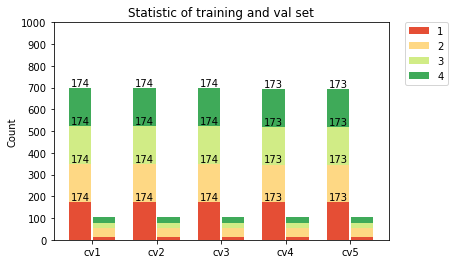

In [7]:
# Do 5 fold cross validation and imbalance adjustment
df = pd.read_csv('/home/b05501009/Jubo/9_17/dataset/train.csv')
image_dir = '/home/b05501009/Jubo/7_30/CropedImages'
X = df[['path']]
Y = df[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
one_list = []
two_list = []
thr_list = []
for_list = []

one_count = 0
two_count = 0
thr_count = 0
for_count = 0

trone = []
trtwo = []
trthr = []
trfor = []

valone = []
valtwo = []
valthr = []
valfor = []

tronelist = []
trtwolist = []
trthrlist = []
trforlist = []

mean_cv = []
std_cv  = []

# 5 fold
for x,y in skf.split(X,Y):
    
    # get average of dataset before imbalance adjustment
    mean,std = get_mean_std(x)
    mean_cv.append(mean)
    
    # Number before imbalance adjustment
    one_count = 0
    two_count = 0
    thr_count = 0
    for_count = 0
    for i in x:
        if (Y.iloc[i,0]) == 1:
            tronelist.append(i)
            one_count += 1
        elif (Y.iloc[i,0]) == 2:
            trtwolist.append(i)
            two_count += 1
        elif (Y.iloc[i,0]) == 3:
            trthrlist.append(i)
            thr_count += 1
        elif (Y.iloc[i,0]) == 4:
            trforlist.append(i)
            for_count += 1
    
    # imbalance adjustment
    one_imb = two_count - one_count
    thr_imb = two_count - thr_count
    for_imb = two_count - for_count
    
    for i in range(one_imb):
        x = np.append(x,tronelist[i%len(tronelist)])
        
    for i in range(thr_imb):
        x = np.append(x,trthrlist[i%len(trthrlist)])
        
    for i in range(for_imb):
        x = np.append(x,trforlist[i%len(trforlist)])
    
    # Number after imbalance adjustment
    one_count = 0
    two_count = 0
    thr_count = 0
    for_count = 0
    for i in x:
        if (Y.iloc[i,0]) == 1:
            one_count += 1
        elif (Y.iloc[i,0]) == 2:
            two_count += 1
        elif (Y.iloc[i,0]) == 3:
            thr_count += 1
        elif (Y.iloc[i,0]) == 4:
            for_count += 1
            
    trone.append(one_count)
    trtwo.append(two_count)
    trthr.append(thr_count)
    trfor.append(for_count)
    
    one_count = 0
    two_count = 0
    thr_count = 0
    for_count = 0
    
    for i in y:
        if (Y.iloc[i,0]) == 1:
            one_count += 1
        elif (Y.iloc[i,0]) == 2:
            two_count += 1
        elif (Y.iloc[i,0]) == 3:
            thr_count += 1
        elif (Y.iloc[i,0]) == 4:
            for_count += 1
    print('validation:',one_count,two_count,thr_count,for_count)    
    
    valone.append(one_count)
    valtwo.append(two_count)
    valthr.append(thr_count)
    valfor.append(for_count)

# Visualized data number in each stage
labels = ['cv1','cv2','cv3','cv4','cv5']
N = 5
category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, 4))
ind = np.arange(N)  
width = 0.35       
x = np.arange(len(labels)) 
p1 = plt.bar(x - width/2 - 0.01, trone, width ,label='1',
            color = category_colors[0])
p2 = plt.bar(x - width/2 - 0.01, trtwo, width, bottom = trone, label='2',
            color = category_colors[1])
p3 = plt.bar(x - width/2 - 0.01, trthr, width, bottom = list(np.array(trone)+np.array(trtwo)), label='3',
            color = category_colors[2])
p4 = plt.bar(x - width/2 - 0.01, trfor, width, bottom = list(np.array(trone)+np.array(trtwo)+np.array(trthr)), label='4',
            color = category_colors[3])
p5 = plt.bar(x + width/2 + 0.01, valone, width ,label='1',
             color=p1[0].get_facecolor())
p6 = plt.bar(x + width/2 + 0.01, valtwo, width, bottom = valone, label='2',
             color=p2[0].get_facecolor())
p7 = plt.bar(x + width/2 + 0.01, valthr, width,
             bottom = list(np.array(valone)+np.array(valtwo)), label='3',
             color=p3[0].get_facecolor())
p8 = plt.bar(x + width/2 + 0.01, valfor, width, 
             bottom = list(np.array(valone)+np.array(valtwo)+np.array(valthr)), label='4',
             color=p4[0].get_facecolor())

plt.ylabel('Count')
plt.title('Statistic of training and val set')
plt.xticks(ind,labels)
plt.yticks(np.arange(0, 1001, 100))
plt.legend()
plt.legend((p1[0], p2[0],p3[0],p4[0]), ('1', '2','3','4'),bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

autolabel(p1)
autolabel2(p2)
autolabel3(p3)
autolabel4(p4)

print('total training:',trone[0]+trtwo[0]+trthr[0]+trfor[0])
print('total validation:',valone[0]+valtwo[0]+valthr[0]+valfor[0])
plt.show()

In [7]:
# get_mean_std is too long, save here for any further debugging
mean_cv=[[138.29072524854806,101.59556888855637,90.5855904341772],
         [135.90955342165324,104.07227004537611,94.77185126577594],
         [138.42849909125331,101.57745632922048,90.37474428211216],
         [137.66812578438496,100.40135476703855,89.1531830063646],
         [137.05848570963676,101.44234882910892,90.65468411166596]]

In [8]:
# Data Preprocess：zero-shifted RGB three channel
R_mean = np.zeros((224,224))
for i in range(R_mean.shape[0]):
    for j in range(R_mean.shape[1]):
        R_mean [i][j] = mean_cv[0][0]

G_mean = np.zeros((224,224))
for i in range(G_mean.shape[0]):
    for j in range(G_mean.shape[1]):
        G_mean [i][j] = mean_cv[0][1]

B_mean = np.zeros((224,224))
for i in range(B_mean.shape[0]):
    for j in range(B_mean.shape[1]):
        B_mean [i][j] = mean_cv[0][2]


def minus_mean(img):
    img_copy = img.copy()
    img_copy[:,:,0] = img[:,:,2] - B_mean
    img_copy[:,:,1] = img[:,:,1] - G_mean
    img_copy[:,:,2] = img[:,:,0] - R_mean
    return img_copy


In [ ]:
# Look at the preprocess photo 
# Make sure that：
# Grade 1: [1,0,0,0]
# Grade 2: [0,1,0,0]
# Grade 3: [0,0,1,0]
# Grade 4: [0,0,0,1]

image_dir = '/home/b05501009/Jubo/7_30/CropedImages'
df = pd.read_csv('/home/b05501009/Jubo/7_30/dataset/check.csv')
df['label'] = df['label'].astype(str)
X = df[['path']]
Y = df[['label']]


train_index = [0,1,2,3]
val_index = [0,1,2,3]
training_data = df.iloc[train_index]
validation_data = df.iloc[val_index]
train_datagen = ImageDataGenerator(preprocessing_function=minus_mean)
train_data_generator = train_datagen.flow_from_dataframe(training_data, 
                                                         directory = image_dir,
                                                         x_col = "path", 
                                                         y_col = "label",
                                                         class_mode = "categorical" ,
                                                         shuffle = False,
                                                         target_size = (224,224),
                                                         batch_size = 64,
                                                         seed = 10)
val_data_generator = train_datagen.flow_from_dataframe(validation_data,
                                                       directory = image_dir,
                                                       x_col = "path", 
                                                       y_col = "label",
                                                       class_mode = "categorical" ,
                                                       shuffle = True,
                                                       target_size = (224,224),
                                                       batch_size = 64,
                                                       seed = 10)    

for (x,y) in train_data_generator :
    plt.imshow(x[0][:,:,:])
    plt.show()
    print(y[0])
    plt.imshow(x[1][:,:,:])
    plt.show()
    print(y[1])
    plt.imshow(x[2][:,:,:])
    plt.show()
    print(y[2])
    plt.imshow(x[3][:,:,:])
    plt.show()
    print(y[3])
    break


Found 696 validated image filenames belonging to 4 classes.
Found 106 validated image filenames belonging to 4 classes.
Train for 44.0 steps, validate for 7.0 steps
Epoch 1/200
41/44 [==========================>...] - ETA: 0s - loss: 0.8714 - acc: 0.6651
Epoch 00001: val_acc improved from -inf to 0.53774, saving model to /home/b05501009/Jubo/9_26/model/VGG16_self_preprocess_fold_1.hdf5
44/44 [==============================] - 15s 332ms/step - loss: 0.8442 - acc: 0.6782 - val_loss: 1.2189 - val_acc: 0.5377
Epoch 2/200
42/44 [===========================>..] - ETA: 0s - loss: 0.1795 - acc: 0.9639
Epoch 00002: val_acc improved from 0.53774 to 0.64151, saving model to /home/b05501009/Jubo/9_26/model/VGG16_self_preprocess_fold_1.hdf5
44/44 [==============================] - 9s 214ms/step - loss: 0.1752 - acc: 0.9655 - val_loss: 1.1613 - val_acc: 0.6415
Epoch 3/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0620 - acc: 0.9955
Epoch 00003: val_acc improved from 0.64151 to 0.707

Epoch 58/200
43/44 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 1.0000
Epoch 00058: val_acc did not improve from 0.78302
44/44 [==============================] - 5s 112ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 1.3744 - val_acc: 0.7736
Epoch 59/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00059: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00059: val_acc did not improve from 0.78302
44/44 [==============================] - 5s 113ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.3749 - val_acc: 0.7642
Epoch 60/200
43/44 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00060: val_acc did not improve from 0.78302
44/44 [==============================] - 5s 110ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 1.3732 - val_acc: 0.7736
Epoch 61/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00061: val_acc did not improve from 

Epoch 88/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0023 - acc: 1.0000
Epoch 00088: val_acc did not improve from 0.78302
44/44 [==============================] - 5s 112ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.3746 - val_acc: 0.7642
Epoch 89/200
43/44 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00089: ReduceLROnPlateau reducing learning rate to 7.629394893626795e-09.

Epoch 00089: val_acc did not improve from 0.78302
44/44 [==============================] - 5s 113ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.3760 - val_acc: 0.7642
Epoch 90/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00090: val_acc did not improve from 0.78302
44/44 [==============================] - 5s 113ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.3755 - val_acc: 0.7736
Epoch 91/200
43/44 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 1.0000
Epoch 00091: val_acc did not improve from 

41/44 [==========================>...] - ETA: 0s - loss: 0.0026 - acc: 1.0000
Epoch 00146: val_acc did not improve from 0.78302
44/44 [==============================] - 5s 112ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.3733 - val_acc: 0.7642
Epoch 147/200
43/44 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 1.0000
Epoch 00147: val_acc did not improve from 0.78302
44/44 [==============================] - 5s 113ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 1.3748 - val_acc: 0.7642
Epoch 148/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00148: val_acc did not improve from 0.78302
44/44 [==============================] - 5s 114ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.3760 - val_acc: 0.7642
Epoch 149/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0026 - acc: 1.0000
Epoch 00149: ReduceLROnPlateau reducing learning rate to 1.8626452377018543e-12.

Epoch 00149: val_acc did not improve from 0.78302
4

Epoch 176/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0023 - acc: 1.0000
Epoch 00176: val_acc did not improve from 0.78302
44/44 [==============================] - 5s 114ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.3736 - val_acc: 0.7736
Epoch 177/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0026 - acc: 1.0000
Epoch 00177: val_acc did not improve from 0.78302
44/44 [==============================] - 5s 116ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 1.3731 - val_acc: 0.7736
Epoch 178/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0026 - acc: 1.0000
Epoch 00178: val_acc did not improve from 0.78302
44/44 [==============================] - 5s 111ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.3714 - val_acc: 0.7736
Epoch 179/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0026 - acc: 1.0000
Epoch 00179: val_acc did not improve from 0.78302
44/44 [==============================] - 5s 113ms/step - loss: 0.0025

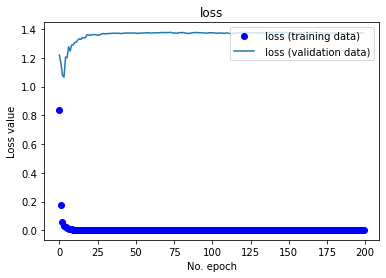

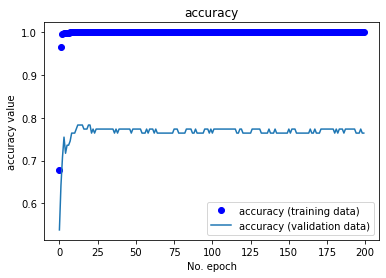

best Acc: 0.7830189
best fold: 1
Found 696 validated image filenames belonging to 4 classes.
Found 106 validated image filenames belonging to 4 classes.
Train for 44.0 steps, validate for 7.0 steps
Epoch 1/200
41/44 [==========================>...] - ETA: 0s - loss: 0.8372 - acc: 0.6404
Epoch 00001: val_acc improved from -inf to 0.71698, saving model to /home/b05501009/Jubo/9_26/model/VGG16_self_preprocess_fold_2.hdf5
44/44 [==============================] - 9s 195ms/step - loss: 0.8325 - acc: 0.6422 - val_loss: 0.7738 - val_acc: 0.7170
Epoch 2/200
43/44 [============================>.] - ETA: 0s - loss: 0.1893 - acc: 0.9603
Epoch 00002: val_acc improved from 0.71698 to 0.89623, saving model to /home/b05501009/Jubo/9_26/model/VGG16_self_preprocess_fold_2.hdf5
44/44 [==============================] - 6s 143ms/step - loss: 0.1995 - acc: 0.9569 - val_loss: 0.3623 - val_acc: 0.8962
Epoch 3/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0703 - acc: 0.9895
Epoch 00003: val_ac

Epoch 30/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0031 - acc: 1.0000
Epoch 00030: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 115ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.4840 - val_acc: 0.8679
Epoch 31/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0029 - acc: 1.0000
Epoch 00031: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 115ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.4851 - val_acc: 0.8679
Epoch 32/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0029 - acc: 1.0000
Epoch 00032: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 117ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.4862 - val_acc: 0.8679
Epoch 33/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0031 - acc: 1.0000
Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00033: val_acc did not improve from

Epoch 60/200
43/44 [============================>.] - ETA: 0s - loss: 0.0028 - acc: 1.0000
Epoch 00060: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 113ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.4872 - val_acc: 0.8679
Epoch 61/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0028 - acc: 1.0000
Epoch 00061: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 113ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.4888 - val_acc: 0.8679
Epoch 62/200
43/44 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00062: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 114ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.4892 - val_acc: 0.8679
Epoch 63/200
43/44 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 1.0000
Epoch 00063: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00063: val_acc did not improve from

Epoch 90/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0028 - acc: 1.0000
Epoch 00090: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 110ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.4857 - val_acc: 0.8679
Epoch 91/200
43/44 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 1.0000
Epoch 00091: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 111ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.4872 - val_acc: 0.8679
Epoch 92/200
43/44 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00092: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 111ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.4878 - val_acc: 0.8679
Epoch 93/200
43/44 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00093: ReduceLROnPlateau reducing learning rate to 3.814697446813398e-09.

Epoch 00093: val_acc did not improve from 

Epoch 149/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0027 - acc: 1.0000
Epoch 00149: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 112ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.4903 - val_acc: 0.8679
Epoch 150/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0028 - acc: 1.0000
Epoch 00150: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 111ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.4899 - val_acc: 0.8679
Epoch 151/200
43/44 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 1.0000
Epoch 00151: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 112ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.4866 - val_acc: 0.8679
Epoch 152/200
43/44 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 1.0000
Epoch 00152: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 110ms/step - loss: 0.0027

Epoch 179/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0029 - acc: 1.0000
Epoch 00179: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 111ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.4868 - val_acc: 0.8679
Epoch 180/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0028 - acc: 1.0000
Epoch 00180: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 113ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.4869 - val_acc: 0.8679
Epoch 181/200
43/44 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00181: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 110ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.4858 - val_acc: 0.8679
Epoch 182/200
43/44 [============================>.] - ETA: 0s - loss: 0.0028 - acc: 1.0000
Epoch 00182: val_acc did not improve from 0.89623
44/44 [==============================] - 5s 110ms/step - loss: 0.0028

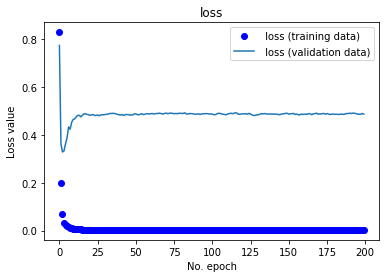

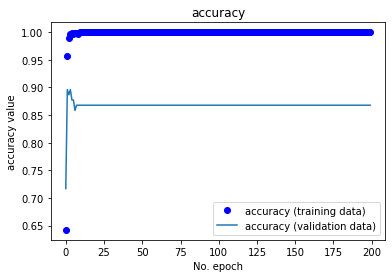

best Acc: 0.8962264
best fold: 2
Found 696 validated image filenames belonging to 4 classes.
Found 106 validated image filenames belonging to 4 classes.
Train for 44.0 steps, validate for 7.0 steps
Epoch 1/200
42/44 [===========================>..] - ETA: 0s - loss: 0.8525 - acc: 0.6431
Epoch 00001: val_acc improved from -inf to 0.70755, saving model to /home/b05501009/Jubo/9_26/model/VGG16_self_preprocess_fold_3.hdf5
44/44 [==============================] - 8s 192ms/step - loss: 0.8339 - acc: 0.6523 - val_loss: 0.7195 - val_acc: 0.7075
Epoch 2/200
41/44 [==========================>...] - ETA: 0s - loss: 0.2010 - acc: 0.9552
Epoch 00002: val_acc improved from 0.70755 to 0.83962, saving model to /home/b05501009/Jubo/9_26/model/VGG16_self_preprocess_fold_3.hdf5
44/44 [==============================] - 6s 144ms/step - loss: 0.1989 - acc: 0.9569 - val_loss: 0.3551 - val_acc: 0.8396
Epoch 3/200
43/44 [============================>.] - ETA: 0s - loss: 0.0681 - acc: 0.9926
Epoch 00003: val_ac

Epoch 29/200
43/44 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 1.0000
Epoch 00029: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 111ms/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.4253 - val_acc: 0.8774
Epoch 30/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0032 - acc: 1.0000
Epoch 00030: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 113ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.4246 - val_acc: 0.8774
Epoch 31/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0031 - acc: 1.0000
Epoch 00031: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 112ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.4257 - val_acc: 0.8774
Epoch 32/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0032 - acc: 1.0000
Epoch 00032: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 111ms/step - loss: 0.0032 - a

Epoch 59/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00059: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 110ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.4245 - val_acc: 0.8774
Epoch 60/200
43/44 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 1.0000
Epoch 00060: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 111ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.4265 - val_acc: 0.8774
Epoch 61/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00061: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 111ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.4292 - val_acc: 0.8774
Epoch 62/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00062: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 111ms/step - loss: 0.0030 - a

Epoch 89/200
43/44 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00089: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 109ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.4242 - val_acc: 0.8774
Epoch 90/200
43/44 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00090: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 111ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.4257 - val_acc: 0.8774
Epoch 91/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0029 - acc: 1.0000
Epoch 00091: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 109ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.4278 - val_acc: 0.8774
Epoch 92/200
43/44 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00092: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 109ms/step - loss: 0.0029 - a

Epoch 119/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0029 - acc: 1.0000
Epoch 00119: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 112ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.4278 - val_acc: 0.8774
Epoch 120/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0029 - acc: 1.0000
Epoch 00120: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 111ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.4295 - val_acc: 0.8774
Epoch 121/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0032 - acc: 1.0000
Epoch 00121: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 110ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.4286 - val_acc: 0.8774
Epoch 122/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0029 - acc: 1.0000
Epoch 00122: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 110ms/step - loss: 0.0030

Epoch 149/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0031 - acc: 1.0000
Epoch 00149: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 108ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.4236 - val_acc: 0.8774
Epoch 150/200
43/44 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00150: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 109ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.4260 - val_acc: 0.8774
Epoch 151/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0029 - acc: 1.0000
Epoch 00151: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 109ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.4275 - val_acc: 0.8774
Epoch 152/200
43/44 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00152: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 110ms/step - loss: 0.0029

Epoch 179/200
43/44 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00179: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 110ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.4279 - val_acc: 0.8774
Epoch 180/200
43/44 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00180: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 107ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.4266 - val_acc: 0.8774
Epoch 181/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0029 - acc: 1.0000
Epoch 00181: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 114ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.4275 - val_acc: 0.8868
Epoch 182/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0029 - acc: 1.0000
Epoch 00182: val_acc did not improve from 0.91509
44/44 [==============================] - 5s 110ms/step - loss: 0.0029

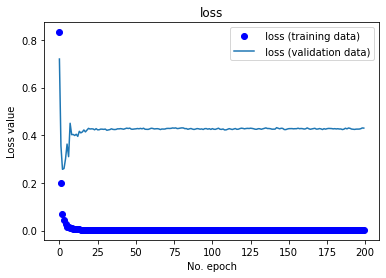

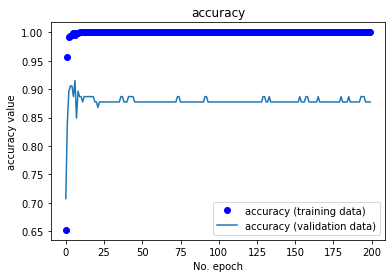

best Acc: 0.9150944
best fold: 3
Found 692 validated image filenames belonging to 4 classes.
Found 106 validated image filenames belonging to 4 classes.
Train for 44.0 steps, validate for 7.0 steps
Epoch 1/200
42/44 [===========================>..] - ETA: 0s - loss: 0.8092 - acc: 0.6636
Epoch 00001: val_acc improved from -inf to 0.76415, saving model to /home/b05501009/Jubo/9_26/model/VGG16_self_preprocess_fold_4.hdf5
44/44 [==============================] - 8s 187ms/step - loss: 0.7872 - acc: 0.6720 - val_loss: 0.5634 - val_acc: 0.7642
Epoch 2/200
41/44 [==========================>...] - ETA: 0s - loss: 0.1786 - acc: 0.9488
Epoch 00002: val_acc improved from 0.76415 to 0.83019, saving model to /home/b05501009/Jubo/9_26/model/VGG16_self_preprocess_fold_4.hdf5
44/44 [==============================] - 8s 179ms/step - loss: 0.1760 - acc: 0.9494 - val_loss: 0.5183 - val_acc: 0.8302
Epoch 3/200
43/44 [============================>.] - ETA: 0s - loss: 0.0529 - acc: 0.9956
Epoch 00003: val_ac

43/44 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 1.0000
Epoch 00029: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 112ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.4247 - val_acc: 0.8962
Epoch 30/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00030: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 112ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4269 - val_acc: 0.8962
Epoch 31/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00031: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 113ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.4258 - val_acc: 0.8962
Epoch 32/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00032: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 111ms/step - loss: 0.0024 - acc: 1.0000 - 

Epoch 59/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0023 - acc: 1.0000
Epoch 00059: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 112ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4310 - val_acc: 0.8962
Epoch 60/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0023 - acc: 1.0000
Epoch 00060: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 111ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4309 - val_acc: 0.8962
Epoch 61/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00061: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 111ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4296 - val_acc: 0.8962
Epoch 62/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0022 - acc: 1.0000
Epoch 00062: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 111ms/step - loss: 0.0022 - a

Epoch 89/200
43/44 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00089: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 111ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.4293 - val_acc: 0.8962
Epoch 90/200
43/44 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 1.0000
Epoch 00090: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 111ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4307 - val_acc: 0.8962
Epoch 91/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00091: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 108ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4317 - val_acc: 0.8962
Epoch 92/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00092: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 110ms/step - loss: 0.0024 - a

Epoch 119/200
43/44 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00119: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 111ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4258 - val_acc: 0.8962
Epoch 120/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00120: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 110ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.4272 - val_acc: 0.8962
Epoch 121/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00121: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 109ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4279 - val_acc: 0.8962
Epoch 122/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0022 - acc: 1.0000
Epoch 00122: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 112ms/step - loss: 0.0022

Epoch 149/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00149: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 112ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.4271 - val_acc: 0.8962
Epoch 150/200
43/44 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00150: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 114ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.4269 - val_acc: 0.8962
Epoch 151/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0023 - acc: 1.0000
Epoch 00151: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 117ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4268 - val_acc: 0.8962
Epoch 152/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00152: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 110ms/step - loss: 0.0024

Epoch 179/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0023 - acc: 1.0000
Epoch 00179: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 113ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.4287 - val_acc: 0.8962
Epoch 180/200
43/44 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 1.0000
Epoch 00180: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 111ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4296 - val_acc: 0.8962
Epoch 181/200
43/44 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 1.0000
Epoch 00181: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 112ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.4298 - val_acc: 0.8962
Epoch 182/200
43/44 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00182: val_acc did not improve from 0.90566
44/44 [==============================] - 5s 109ms/step - loss: 0.0023

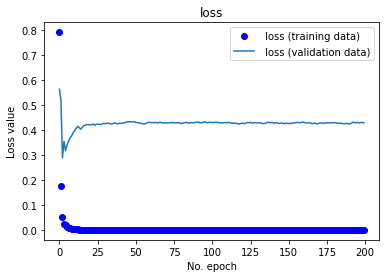

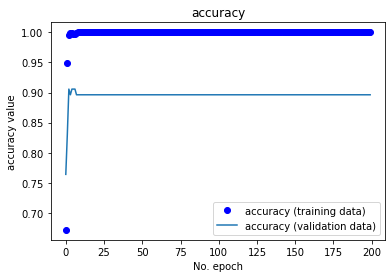

best Acc: 0.9150944
best fold: 3
Found 692 validated image filenames belonging to 4 classes.
Found 106 validated image filenames belonging to 4 classes.
Train for 44.0 steps, validate for 7.0 steps
Epoch 1/200
42/44 [===========================>..] - ETA: 0s - loss: 0.8236 - acc: 0.6394
Epoch 00001: val_acc improved from -inf to 0.77358, saving model to /home/b05501009/Jubo/9_26/model/VGG16_self_preprocess_fold_5.hdf5
44/44 [==============================] - 8s 172ms/step - loss: 0.8057 - acc: 0.6488 - val_loss: 0.6450 - val_acc: 0.7736
Epoch 2/200
43/44 [============================>.] - ETA: 0s - loss: 0.1753 - acc: 0.9660
Epoch 00002: val_acc improved from 0.77358 to 0.83019, saving model to /home/b05501009/Jubo/9_26/model/VGG16_self_preprocess_fold_5.hdf5
44/44 [==============================] - 6s 143ms/step - loss: 0.1760 - acc: 0.9653 - val_loss: 0.4980 - val_acc: 0.8302
Epoch 3/200
43/44 [============================>.] - ETA: 0s - loss: 0.0632 - acc: 0.9896
Epoch 00003: val_ac

Epoch 29/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0027 - acc: 1.0000
Epoch 00029: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 110ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.4709 - val_acc: 0.8868
Epoch 30/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0026 - acc: 1.0000
Epoch 00030: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 111ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.4720 - val_acc: 0.8868
Epoch 31/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0027 - acc: 1.0000
Epoch 00031: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 109ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.4671 - val_acc: 0.8868
Epoch 32/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0026 - acc: 1.0000
Epoch 00032: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 111ms/step - loss: 0.0026 - a

Epoch 59/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0023 - acc: 1.0000
Epoch 00059: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 113ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4721 - val_acc: 0.8868
Epoch 60/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00060: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 112ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.4687 - val_acc: 0.8868
Epoch 61/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00061: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 114ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4696 - val_acc: 0.8868
Epoch 62/200
43/44 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 1.0000
Epoch 00062: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 108ms/step - loss: 0.0027 - a

Epoch 89/200
43/44 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 1.0000
Epoch 00089: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 111ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4700 - val_acc: 0.8868
Epoch 90/200
43/44 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00090: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 111ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.4713 - val_acc: 0.8868
Epoch 91/200
43/44 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00091: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 116ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4690 - val_acc: 0.8868
Epoch 92/200
43/44 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00092: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 113ms/step - loss: 0.0025 - a

Epoch 119/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00119: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 110ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4693 - val_acc: 0.8868
Epoch 120/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00120: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 118ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.4707 - val_acc: 0.8868
Epoch 121/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00121: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 110ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4728 - val_acc: 0.8868
Epoch 122/200
43/44 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00122: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 113ms/step - loss: 0.0025

Epoch 149/200
43/44 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00149: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 112ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4707 - val_acc: 0.8868
Epoch 150/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00150: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 112ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.4712 - val_acc: 0.8868
Epoch 151/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0023 - acc: 1.0000
Epoch 00151: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 111ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4694 - val_acc: 0.8868
Epoch 152/200
43/44 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 1.0000
Epoch 00152: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 111ms/step - loss: 0.0025

Epoch 179/200
42/44 [===========================>..] - ETA: 0s - loss: 0.0023 - acc: 1.0000
Epoch 00179: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 109ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4671 - val_acc: 0.8868
Epoch 180/200
43/44 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00180: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 110ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.4671 - val_acc: 0.8868
Epoch 181/200
43/44 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 1.0000
Epoch 00181: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 112ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4662 - val_acc: 0.8868
Epoch 182/200
43/44 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 1.0000
Epoch 00182: val_acc did not improve from 0.88679
44/44 [==============================] - 5s 107ms/step - loss: 0.0025

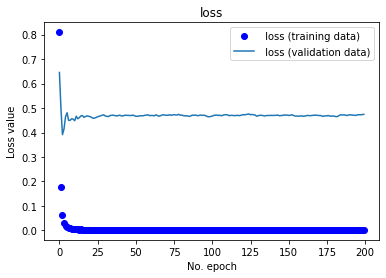

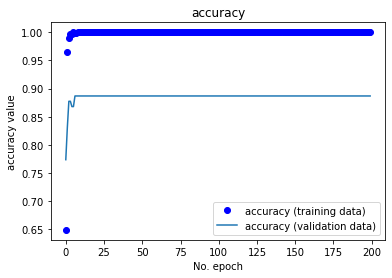

best Acc: 0.9150944
best fold: 3


In [10]:
# Training
df = pd.read_csv('/home/b05501009/Jubo/9_17/dataset/train.csv')
X = df['path']
Y = df['label']
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
one_list = []
two_list = []
thr_list = []
for_list = []

one_count = 0
two_count = 0
thr_count = 0
for_count = 0

trone = []
trtwo = []
trthr = []
trfor = []

valone = []
valtwo = []
valthr = []
valfor = []

tronelist = []
trtwolist = []
trthrlist = []
trforlist = []

best_fold = 0
best_acc = 0

c = 1
for x,y in skf.split(X,Y):
    one_count = 0
    two_count = 0
    thr_count = 0
    for_count = 0
    for i in x:
        if (Y.iloc[i]) == 1:
            tronelist.append(i)
            one_count += 1
        elif (Y.iloc[i]) == 2:
            trtwolist.append(i)
            two_count += 1
        elif (Y.iloc[i]) == 3:
            trthrlist.append(i)
            thr_count += 1
        elif (Y.iloc[i]) == 4:
            trforlist.append(i)
            for_count += 1
    
    #imbalance
    one_imb = two_count - one_count
    thr_imb = two_count - thr_count
    for_imb = two_count - for_count
    
    for i in range(one_imb):
        x = np.append(x,tronelist[i%len(tronelist)])
        one_count+=1
        
    for i in range(thr_imb):
        x = np.append(x,trthrlist[i%len(trthrlist)])
        thr_count+=1    
        
    for i in range(for_imb):
        x = np.append(x,trforlist[i%len(trforlist)])
        for_count+=1
        
    trone.append(one_count)
    trtwo.append(two_count)
    trthr.append(thr_count)
    trfor.append(for_count)
    
    one_count = 0
    two_count = 0
    thr_count = 0
    for_count = 0
    
    for i in y:
        if (Y.iloc[i]) == 1:
            one_count += 1
        elif (Y.iloc[i]) == 2:
            two_count += 1
        elif (Y.iloc[i]) == 3:
            thr_count += 1
        elif (Y.iloc[i]) == 4:
            for_count += 1 
    
    valone.append(one_count)
    valtwo.append(two_count)
    valthr.append(thr_count)
    valfor.append(for_count)
    
    
    df['label'] = df['label'].astype(str)
    
    training_data = df.iloc[x]
    validation_data = df.iloc[y]

    train_datagen = ImageDataGenerator(preprocessing_function=minus_mean)

    train_data_generator = train_datagen.flow_from_dataframe(training_data, 
                                                             directory = image_dir,
                                                             x_col = "path", 
                                                             y_col = "label",
                                                             class_mode = "categorical" ,
                                                             shuffle = True,
                                                             target_size = (224,224),
                                                             batch_size = 16,
                                                             seed = 10)

    val_data_generator = train_datagen.flow_from_dataframe(validation_data,
                                                           directory = image_dir,
                                                           x_col = "path", 
                                                           y_col = "label",
                                                           class_mode = "categorical" ,
                                                           shuffle = True,
                                                           target_size = (224,224),
                                                           batch_size = 16,
                                                           seed = 10)     
    
    base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
    base_model.trainable = False
    top_model = tf.keras.models.Sequential()
    top_model.add(tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(tf.keras.layers.Dense(1024, kernel_initializer='normal'))
    top_model.add(tf.keras.layers.BatchNormalization())
    top_model.add(tf.keras.layers.Dropout(0.5))
    top_model.add(tf.keras.layers.Activation('sigmoid'))
    top_model.add(tf.keras.layers.Dense(1024, kernel_initializer='normal'))
    top_model.add(tf.keras.layers.BatchNormalization())
    top_model.add(tf.keras.layers.Dropout(0.5))
    top_model.add(tf.keras.layers.Activation('sigmoid'))
    top_model.add(tf.keras.layers.Dense(4,activation='softmax'))
    model = tf.keras.models.Model(base_model.inputs, top_model(base_model.output))

    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.001),
                  loss='categorical_crossentropy',
                  metrics=['acc'])    
    
    filepath = os.path.join('/home/b05501009/Jubo/9_26/model',"VGG16_self_preprocess_fold_" + str(c) + ".hdf5")
    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='auto')   
    
    reduce_lr = ReduceLROnPlateau(factor = 0.5,
                              monitor = 'val_loss',
                              min_lr = 0.0000000000001,
                              patience = 5,
                              verbose = 1)

    train_step = np.floor(696 / 16)+1
    val_step = np.floor(106/ 16)+1
    model_history = model.fit(train_data_generator,
                              steps_per_epoch=train_step,
                              epochs=200,
                              validation_data=val_data_generator,
                              validation_steps=val_step,
                              verbose=1,
                              callbacks=[reduce_lr,checkpoint]
                              )
    # Plot
    plt.title('loss')
    plt.plot(model_history.history['loss'],'bo', label=' loss (training data)')
    plt.plot(model_history.history['val_loss'], label=' loss (validation data)')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper right")
    plt.savefig("/home/b05501009/Jubo/9_26/plot/VGG16_sort_self_preprocess_fold_" + str(c) + "_loss.jpg")
    plt.show()
    plt.close('all')

    plt.title('accuracy')
    plt.plot(model_history.history['acc'],'bo', label='accuracy (training data)')
    plt.plot(model_history.history['val_acc'], label='accuracy (validation data)')
    plt.ylabel('accuracy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="lower right")
    plt.savefig("/home/b05501009/Jubo/9_26/plot/VGG16_sort_self_preprocess_fold_" + str(c) + "_acc.jpg")
    plt.show()
    plt.close('all')
    
    if max(model_history.history['val_acc']) > best_acc:
        best_acc = max(model_history.history['val_acc'])
        best_fold = c
    print('best Acc:',best_acc)
    print('best fold:',best_fold)
    
    c+=1

Found 104 validated image filenames belonging to 4 classes.
VGG16_self_preprocess_fold_1
104/104 [==============================] - 4s 41ms/step


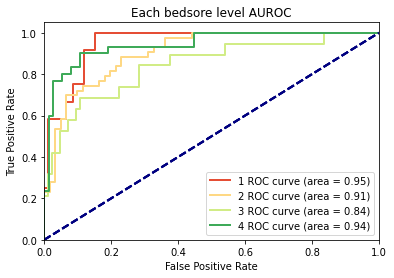

/home/b05501009/.conda/envs/tensorflow2.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/b05501009/.conda/envs/tensorflow2.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator


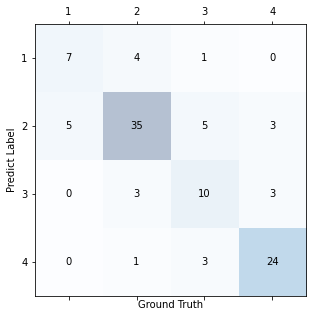

Acc: 73.08%
VGG16_self_preprocess_fold_2
104/104 [==============================] - 1s 13ms/step


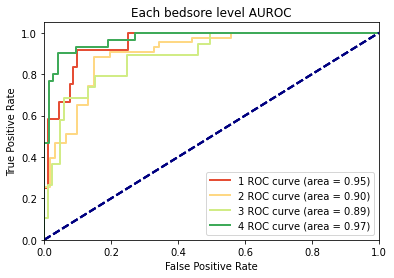

/home/b05501009/.conda/envs/tensorflow2.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/b05501009/.conda/envs/tensorflow2.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator


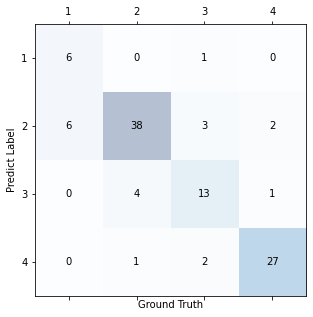

Acc: 80.77%
VGG16_self_preprocess_fold_3
104/104 [==============================] - 1s 13ms/step


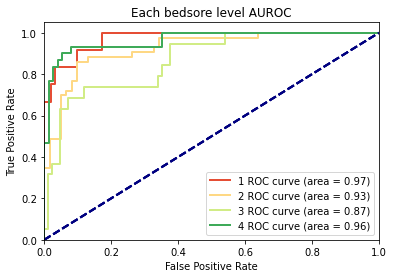

/home/b05501009/.conda/envs/tensorflow2.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/b05501009/.conda/envs/tensorflow2.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator


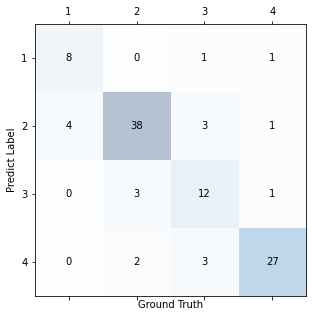

Acc: 81.73%
VGG16_self_preprocess_fold_4
104/104 [==============================] - 1s 13ms/step


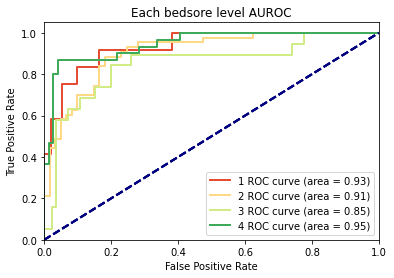

/home/b05501009/.conda/envs/tensorflow2.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/b05501009/.conda/envs/tensorflow2.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator


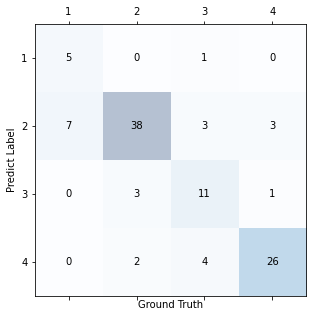

Acc: 76.92%
VGG16_self_preprocess_fold_5
104/104 [==============================] - 1s 13ms/step


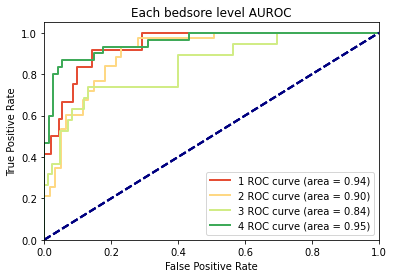

/home/b05501009/.conda/envs/tensorflow2.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/b05501009/.conda/envs/tensorflow2.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator


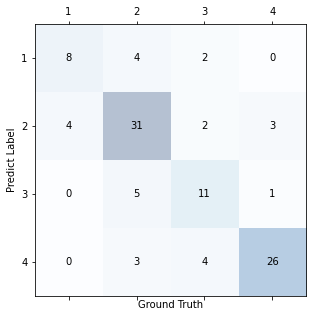

Acc: 73.08%


In [12]:
# testing
cv1               = []
cv2               = []
cv3               = []
cv4               = []
cv5               = []
predict_list      = []

df = pd.read_csv('/home/b05501009/Jubo/9_17/dataset/test.csv')
df['label'] = df['label'].astype(str)
name = []
name.append(list(df['path']))
test_datagen = ImageDataGenerator(
    preprocessing_function=minus_mean) 
image_dir = '/home/b05501009/Jubo/7_30/CropedImages/'
test_generator=test_datagen.flow_from_dataframe(
    dataframe=df, 
    directory=image_dir,
    x_col="path",
    y_col= "label",
    class_mode="categorical",
    target_size=(224,224),
    batch_size=1,
    Seed = 10,
    shuffle = False
)
test_generator.reset()

model_base = "VGG16_self_preprocess_fold_"

for c in range(5):
    model_name = model_base+ str(c+1)
    model_path = os.path.join('/home/b05501009/Jubo/9_26/model',model_base + str(c+1) + ".hdf5")
    print(model_name)
    model = tf.keras.models.load_model(model_path)
    y_test=model.predict(test_generator,verbose=1)

    # AUROC
    y_label = np.array(df['label'].astype(float))

    y_label_one = []
    y_label_two = []
    y_label_thr = []
    y_label_for = []

    for i in range(len(y_label)):
        if i < 12 :
            y_label_one.append(1) 
        else:
            y_label_one.append(0) 

        if  12<= i <55 :
            y_label_two.append(1)
        else:
            y_label_two.append(0)

        if  55<= i <74 :
            y_label_thr.append(1)
        else:
            y_label_thr.append(0)

        if  74<= i :
            y_label_for.append(1)
        else:
            y_label_for.append(0)

    category_colors = plt.get_cmap('RdYlGn')(
            np.linspace(0.15, 0.85, 4))
    fpr,tpr,_ =sklearn.metrics.roc_curve(y_label_one,y_test[:,0])
    roc_auc = auc(fpr,tpr) 
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color=category_colors[0],
             lw=lw, label='1 ROC curve (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    fpr,tpr,_ =sklearn.metrics.roc_curve(y_label_two,y_test[:,1])
    roc_auc = auc(fpr,tpr) 
    plt.plot(fpr, tpr, color=category_colors[1],
             lw=lw, label='2 ROC curve (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    fpr,tpr,_ =sklearn.metrics.roc_curve(y_label_thr,y_test[:,2])
    roc_auc = auc(fpr,tpr) 
    plt.plot(fpr, tpr, color=category_colors[2],
             lw=lw, label='3 ROC curve (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    fpr,tpr,_ =sklearn.metrics.roc_curve(y_label_for,y_test[:,3])
    roc_auc = auc(fpr,tpr) 
    plt.plot(fpr, tpr, color=category_colors[3],
             lw=lw, label='4 ROC curve (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')


    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Each bedsore level AUROC')
    plt.legend(loc="lower right")
    plt.savefig('/home/b05501009/Jubo/9_26/result/'+ model_name +'_AUROC.jpg')
    plt.show()


    # full matrix
    predict_label = []
    for i in range(len(y_test)):

        if y_test[i].tolist().index(max(y_test[i])) == 0:
            predict_label.append(1)
            predict_list.append(1)

        if y_test[i].tolist().index(max(y_test[i])) == 1:
            predict_label.append(2)
            predict_list.append(2)

        if y_test[i].tolist().index(max(y_test[i])) == 2:
            predict_label.append(3)
            predict_list.append(3)

        if y_test[i].tolist().index(max(y_test[i])) == 3:
            predict_label.append(4)
            predict_list.append(4)


    confmat = confusion_matrix(y_true=list(y_label), y_pred=predict_label)
    confmat
    confmat = confmat.T
    fig, ax = plt.subplots(figsize=(5,5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
    plt.xlabel('Ground Truth')        
    plt.ylabel('Predict Label')
    labels = ['1','2','3','4']
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.savefig('/home/b05501009/Jubo/9_26/result/'+model_name+'_matrix.jpg')
    plt.show()
    acc = (confmat[0][0]+ confmat[1][1]+ confmat[2][2]+ confmat[3][3])/sum(sum(confmat))
    print('Acc: {:.2f}%'.format(acc*100))
